In [445]:
import os
import random

import cv2
import dlib
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.svm
import sklearn.tree
import tensorflow as tf
import matplotlib.pyplot as plt

import landmarks

### Implement functions used in all the tasks.

In [446]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def load_images_and_labels(images_dirname, csv_label):
    """Loads images and labels.
    
    Args:
        images_dirname (str): Name of the directory which holds the data.
        csv_label (str): Name of the column from labels.csv to output.

    Returns:
        images (np.ndarray): 4-d array of images, in format np.float32, values between 0 and 1.
        labels (np.ndarray): 1-d array of labels, in format np.int8.
    """
    # get paths of images
    images_dir = os.path.join("./Datasets", images_dirname, "img")
    image_paths = sorted(
        [os.path.join(images_dir, l) for l in os.listdir(images_dir)],
        key=lambda x: int(x.split(".")[1].split("/")[-1]),
    )
    image_paths = image_paths[:5000]  # TODO: remove

    images = []
    for image_path in image_paths:
        image = (
            tf.keras.preprocessing.image.img_to_array(
                tf.keras.preprocessing.image.load_img(image_path), dtype=np.float32
            )
            / 255
        )
        images.append(image)
    images = np.array(images)

    # get labels
    labels_file = open(os.path.join("./Datasets", images_dirname, "labels.csv"), "r")
    lines = labels_file.readlines()
    labels_file.close()
    column = lines[0].split().index(csv_label) + 1
    labels = []
    for line in lines[1:5001]:  # TODO: remove limit
        line = line.split()
        value_to_append = int(line[column])
        # if -1, convert to 0
        labels.append(0 if value_to_append == -1 else value_to_append)
    labels = np.array(labels, dtype=np.int8)

    return images, labels

def shape_to_np(shape):
    """Converts shape returned by dlib into numpy array.

    Args:
        shape (dlib.full_object_detection): Object returned by dlib.
    Returns:
        np.ndarray: Coordinates of the landmarks.
    """
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype="int")

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords


def rect_to_bb(rect):
    """Converts bounding predicted by dlib into (x, y, w, h) format.
    """
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    return (x, y, w, h)


def run_dlib_shape(image):
    """Detects landmarks.

    The function detects the landmarks of the face, then returns the
    landmarks and resized image.
    """
    resized_image = image.astype("uint8")

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype("uint8")

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

def images_into_landmarks(images, labels):
    """Detects landmarks on all images, returns only where landmarks could be found.
    
    Args:
        images (np.ndarray): 4-d array of images, in format np.float32, values between 0 and 1.
        labels (np.ndarray): 1-d array of labels, in format np.int8.
    Returns:
        landmarks (np.ndarray): 3-d array of images, in format np.int16.
        labels (np.ndarray): 1-d array of labels, in format np.int8.
        undetectable (np.ndarray): 1-d array of indexes at which face couldn't be detected. In format int.
    """
    landmarks_detected = []
    labels_detected = []
    undetectable = []
    for i, image in enumerate(images):
        dlibout, _ = run_dlib_shape(image * 255.0)
        if dlibout is not None:
            landmarks_detected.append(dlibout)
            labels_detected.append(labels[i])
        else:
            undetectable.append(i)
    return np.array(landmarks_detected, dtype=np.int16), np.array(labels_detected, dtype=np.int8), undetectable

def flatten_examples(examples):
    """Flattens ndarray except the top dimension.

    Args:
        examples (np.ndarray): Array of examples, each can contain more arrays.
    Returns:
        np.ndarray: 2-d array, where each element is a flattened example.
    """
    return examples.reshape((examples.shape[0], -1))

# Task A1
Gender detection: male or female.

Structure:
* import all images and labels
* plot a few examples to make sure it's imported well
* split into train, validation, test sets
* try a few approaches:
  * use dlib to extract the landmarks, plot overlayed:
    * use a few shallow learning algos and compare, do hyperparameter optimization for each
  * a few shallow algos on pure pixels
  * use CNN
* test on the test set using the best model

##### Import all images and labels.

In [439]:
a1_X_train_raw_images, a1_y_train_raw = load_images_and_labels("celeba", "gender")
a1_X_test_raw_images, a1_y_test_raw = load_images_and_labels("celeba_test", "gender")

##### Plot a few examples to make sure it's imported well.

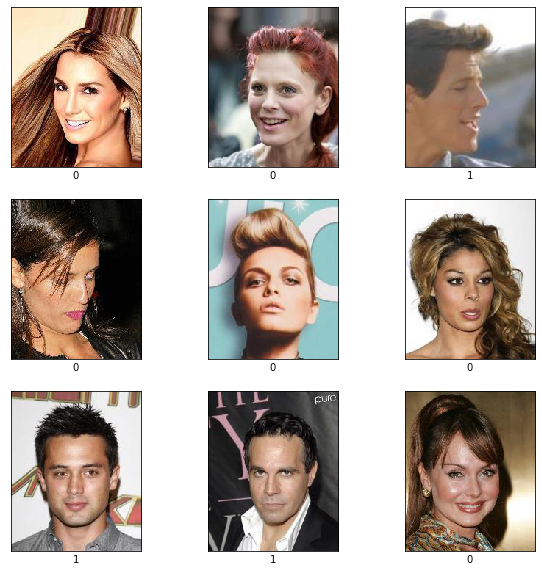

In [270]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(a1_X_train_raw_images[i], cmap=plt.cm.binary)
    plt.xlabel(a1_y_train_raw[i])

plt.show()

##### Split images and labels into train, validation, and test sets.

In [440]:
a1_X_train_images, a1_X_validation_images, a1_y_train, a1_y_validation = sklearn.model_selection.train_test_split(a1_X_train_raw_images, a1_y_train_raw)
a1_X_test_images, a1_y_test = a1_X_test_raw_images, a1_y_test_raw

### Try a few models.
##### Begin with extracting the landmarks using dlib.

In [399]:
a1_X_train_landmarks, a1_y_train_landmarks, undetectable_train = images_into_landmarks(a1_X_train_images, a1_y_train)
a1_X_validation_landmarks, a1_y_validation_landmarks, undetectable_validation = images_into_landmarks(a1_X_validation_images, a1_y_validation)
a1_X_test_landmarks, a1_y_test_landmarks, undetectable_test = images_into_landmarks(a1_X_test_images, a1_y_test)

##### Plot the extracted features on top of the pictures.

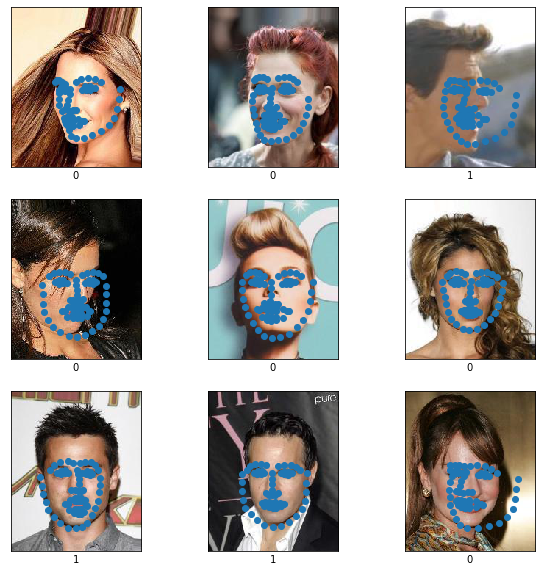

In [465]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(a1_X_train_raw_images[i], cmap=plt.cm.binary)
    plt.xlabel(a1_y_train_raw[i])
    if i in undetectable_train:
        continue
    plt.scatter(a1_X_train_landmarks[i][:, 0], a1_X_train_landmarks[i][:, 1])

plt.show()

##### SVM on landmarks

In [416]:
a1_svm_params = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "kernel": ["linear", "poly", "linear", "sigmoid"]
}
a1_svm = sklearn.model_selection.GridSearchCV(sklearn.svm.SVC(), a1_svm_params)
a1_svm.fit(flatten_examples(a1_X_train_landmarks), a1_y_train_landmarks)
print(a1_svm.best_params_)
a1_pred_svm_validation = a1_svm.predict(flatten_examples(a1_X_validation_landmarks))
sklearn.metrics.accuracy_score(a1_y_validation_landmarks, a1_pred_svm_validation)

{'C': 1.0, 'kernel': 'poly'}


0.8983050847457628

##### Decision tree classifier on landmarks

In [401]:
a1_dtc_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 5, 10, 50, 100, 500, None]
}
a1_dtc = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), a1_dtc_params)
a1_dtc.fit(flatten_examples(a1_X_train_landmarks), a1_y_train_landmarks)
print(a1_dtc.best_params_)
a1_pred_dtc_validation = a1_dtc.predict(flatten_examples(a1_X_validation_landmarks))
sklearn.metrics.accuracy_score(a1_y_validation_landmarks, a1_pred_dtc_validation)

{'criterion': 'gini', 'max_depth': None}


0.847457627118644

##### SVM on all pixels

In [423]:
a1_svm_pixels = sklearn.svm.SVC(C=1.0, kernel="poly")
a1_svm_pixels.fit(flatten_examples(a1_X_train_images), a1_y_train)
a1_pred_svm_pixels_validation = a1_svm_pixels.predict(flatten_examples(a1_X_validation_images))
sklearn.metrics.accuracy_score(a1_y_validation, a1_pred_svm_pixels_validation)

0.776

##### CNN on all pixels

In [433]:
a1_model = tf.keras.models.Sequential()
a1_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(218, 178, 3)))
a1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
a1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
a1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
a1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
a1_model.add(tf.keras.layers.Flatten())
a1_model.add(tf.keras.layers.Dense(64, activation='relu'))
a1_model.add(tf.keras.layers.Dense(2, activation='softmax'))

a1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 216, 176, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 108, 88, 32)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 106, 86, 64)       18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 53, 43, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 51, 41, 64)        36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 133824)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

Train on 3750 samples, validate on 1250 samples
Epoch 1/5
3750/3750 [==============================] - 104s 28ms/sample - loss: 0.4846 - accuracy: 0.7688 - val_loss: 0.2779 - val_accuracy: 0.8992
Epoch 2/5
3750/3750 [==============================] - 107s 29ms/sample - loss: 0.2380 - accuracy: 0.9056 - val_loss: 0.1892 - val_accuracy: 0.9216
Epoch 3/5
3750/3750 [==============================] - 99s 26ms/sample - loss: 0.1568 - accuracy: 0.9405 - val_loss: 0.1780 - val_accuracy: 0.9256
Epoch 4/5
3750/3750 [==============================] - 90s 24ms/sample - loss: 0.0991 - accuracy: 0.9661 - val_loss: 0.1762 - val_accuracy: 0.9352
Epoch 5/5
3750/3750 [==============================] - 88s 23ms/sample - loss: 0.0513 - accuracy: 0.9821 - val_loss: 0.2308 - val_accuracy: 0.9272


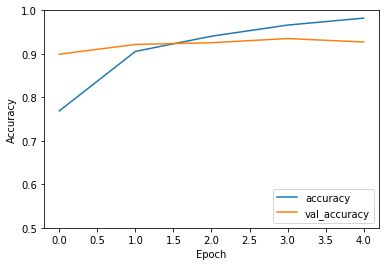

In [434]:
a1_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = a1_model.fit(
    a1_X_train_images,
    a1_y_train,
    epochs=5,
    validation_data=(a1_X_validation_images, a1_y_validation),
)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

In [441]:
_, a1_cnn_test_accuracy = a1_model.evaluate(a1_X_test_images, a1_y_test, verbose=2)

1000/1 - 5s - loss: 0.2558 - accuracy: 0.9100


In [442]:
a1_cnn_test_accuracy

0.91

# Task A2
Emotion detection: smiling or not smiling.

Structure:
* import all images and labels
* no need to split into validation and train sets
* train CNN (clearly the best approach on task A1, so it will be used here)
* report on the test set

##### Import all images and labels.

In [448]:
a2_X_train_raw_images, a2_y_train_raw = load_images_and_labels("celeba", "gender")
a2_X_test_raw_images, a2_y_test_raw = load_images_and_labels("celeba_test", "gender")

In [454]:
a2_X_train_images, a2_y_train = a2_X_train_raw_images, a2_y_train_raw
a2_X_test_images, a2_y_test = a2_X_test_raw_images, a2_y_test_raw

##### CNN on all pixels.

In [455]:
a2_model = tf.keras.models.Sequential()
a2_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(218, 178, 3)))
a2_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
a2_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
a2_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
a2_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
a2_model.add(tf.keras.layers.Flatten())
a2_model.add(tf.keras.layers.Dense(64, activation='relu'))
a2_model.add(tf.keras.layers.Dense(2, activation='softmax'))

a2_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 216, 176, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 108, 88, 32)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 106, 86, 64)       18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 53, 43, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 51, 41, 64)        36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 133824)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

Train on 5000 samples, validate on 1000 samples
Epoch 1/5
5000/5000 [==============================] - 131s 26ms/sample - loss: 0.5025 - accuracy: 0.7646 - val_loss: 0.3612 - val_accuracy: 0.8430
Epoch 2/5
5000/5000 [==============================] - 137s 27ms/sample - loss: 0.2408 - accuracy: 0.9016 - val_loss: 0.2430 - val_accuracy: 0.9080
Epoch 3/5
5000/5000 [==============================] - 129s 26ms/sample - loss: 0.1454 - accuracy: 0.9448 - val_loss: 0.2465 - val_accuracy: 0.9060
Epoch 4/5
5000/5000 [==============================] - 134s 27ms/sample - loss: 0.0948 - accuracy: 0.9632 - val_loss: 0.2333 - val_accuracy: 0.9200
Epoch 5/5
5000/5000 [==============================] - 135s 27ms/sample - loss: 0.0549 - accuracy: 0.9802 - val_loss: 0.2429 - val_accuracy: 0.9210


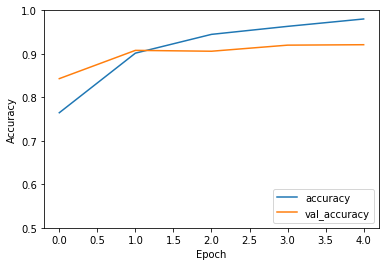

In [456]:
a2_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = a2_model.fit(
    a2_X_train_images,
    a2_y_train,
    epochs=5,
    validation_data=(a2_X_test_images, a2_y_test),
)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

In [457]:
_, a2_cnn_test_accuracy = a2_model.evaluate(a2_X_test_images, a2_y_test, verbose=2)

1000/1 - 7s - loss: 0.2452 - accuracy: 0.9210


In [458]:
a2_cnn_test_accuracy

0.921

# Task B1
Face shape recognition: 5 types of face shapes.

Structure:
* import all images and labels
* plot a few examples to make sure it's imported well
* split into train, validation, test sets
* use dlib to extract the landmarks, plot overlayed
  * try SVM
* use CNN
* test on the test set using CNN

##### Import all images and labels.

In [459]:
b1_X_train_raw_images, b1_y_train_raw = load_images_and_labels("cartoon_set", "face_shape")
b1_X_test_raw_images, b1_y_test_raw = load_images_and_labels("cartoon_set_test", "face_shape")

##### Plot a few examples to make sure it's imported well.

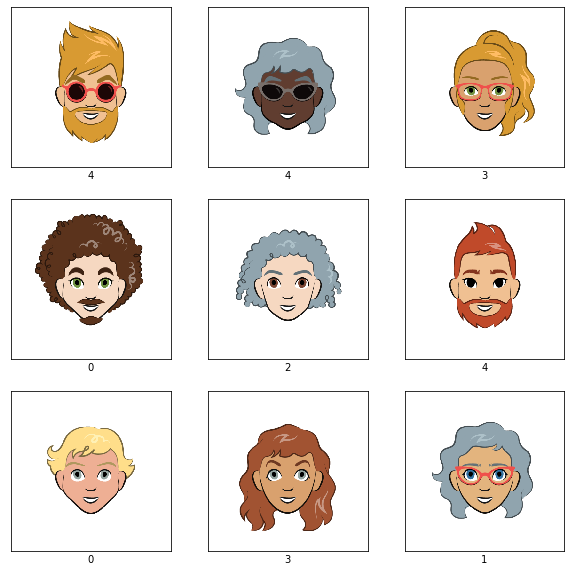

In [462]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(b1_X_train_raw_images[i], cmap=plt.cm.binary)
    plt.xlabel(b1_y_train_raw[i])

plt.show()

##### Split images and labels into train, validation, and test sets.

In [466]:
b1_X_train_images, b1_X_validation_images, b1_y_train, b1_y_validation = sklearn.model_selection.train_test_split(b1_X_train_raw_images, b1_y_train_raw)
b1_X_test_images, b1_y_test = b1_X_test_raw_images, b1_y_test_raw

##### Extract the landmarks using dlib.

In [467]:
b1_X_train_landmarks, b1_y_train_landmarks, undetectable_train = images_into_landmarks(b1_X_train_images, b1_y_train)
b1_X_validation_landmarks, b1_y_validation_landmarks, undetectable_validation = images_into_landmarks(b1_X_validation_images, b1_y_validation)
b1_X_test_landmarks, b1_y_test_landmarks, undetectable_test = images_into_landmarks(b1_X_test_images, b1_y_test)

##### Plot the extracted features on top of the pictures.

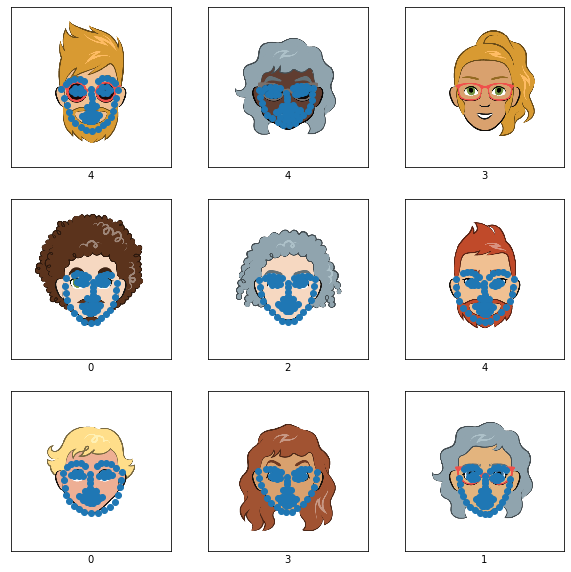

In [483]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(b1_X_train_raw_images[i], cmap=plt.cm.binary)
    plt.xlabel(b1_y_train_raw[i])
    if i in undetectable_train:
        continue
    plt.scatter(b1_X_train_landmarks[i][:, 0], b1_X_train_landmarks[i][:, 1])

plt.show()

The detection is not always very correct, so we don't expect high accuracy here. Let's try SVM on the landmarks.
##### SVM on landmarks

In [484]:
b1_svm = sklearn.svm.SVC(kernel="poly")
b1_svm.fit(flatten_examples(b1_X_train_landmarks), b1_y_train_landmarks)
b1_pred_svm_validation = b1_svm.predict(flatten_examples(b1_X_validation_landmarks))
sklearn.metrics.accuracy_score(b1_y_validation_landmarks, b1_pred_svm_validation)

0.7397660818713451

##### CNN on all pixels

In [482]:
b1_model = tf.keras.models.Sequential()
b1_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)))
b1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
b1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
b1_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
b1_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
b1_model.add(tf.keras.layers.Flatten())
b1_model.add(tf.keras.layers.Dense(64, activation='relu'))
b1_model.add(tf.keras.layers.Dense(5, activation='softmax'))

b1_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 121, 121, 64)      36928     
_________________________________________________________________
flatten_14 (Flatten)         (None, 937024)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)              

In [473]:
b1_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = b1_model.fit(
    b1_X_train_images,
    b1_y_train,
    epochs=5,
    validation_data=(b1_X_validation_images, b1_y_validation),
)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

Train on 3750 samples, validate on 1250 samples
Epoch 1/5
3750/3750 [==============================] - 571s 152ms/sample - loss: 1.8349 - accuracy: 0.7272 - val_loss: 0.0427 - val_accuracy: 0.9856
Epoch 2/5
3750/3750 [==============================] - 500s 133ms/sample - loss: 0.0194 - accuracy: 0.9949 - val_loss: 0.0258 - val_accuracy: 0.9928
Epoch 3/5
1120/3750 [=======>......................] - ETA: 5:58 - loss: 0.0058 - accuracy: 0.9982

KeyboardInterrupt: 

In [474]:
_, b1_cnn_test_accuracy = b1_model.evaluate(b1_X_test_images, b1_y_test, verbose=2)

2500/1 - 92s - loss: 0.0056 - accuracy: 0.9964


In [ ]:
b1_cnn_test_accuracy

# Task B2
Eye color recognition: 5 eye colors.

Eye color label:
* 0 - brown
* 1 - blue
* 2 - green
* 3 - bright green
* 4 - black

Structure:
* import all images and labels
* plot a few examples to make sure it's imported well
* crop images to see eyes only

In [ ]:
def load_images_and_labels(images_dirname):
    # get paths of images
    images_dir = os.path.join("./Datasets", images_dirname, "img")
    image_paths = sorted([os.path.join(images_dir, l) for l in os.listdir(images_dir)], key=lambda x: int(x.split(".")[1].split("/")[-1]))
    image_paths = image_paths[:1000] # TODO: remove
    
    images = []
    for image_path in image_paths:
        image = tf.keras.preprocessing.image.img_to_array(
            tf.keras.preprocessing.image.load_img(
                image_path, target_size=None, interpolation="bicubic"
            )
        )
        images.append(image)
    images = np.array(images, dtype=int)

    # get labels
    labels_file = open(os.path.join("./Datasets", images_dirname, "labels.csv"), "r")
    lines = labels_file.readlines()
    labels_file.close()
    labels = []
    for line in lines[1:1001]:  # TODO: remove limit
        line = line.split()
        labels.append([int(line[1]), int(line[2]), line[3]])

    return images, labels

In [ ]:
b2_X_train_raw, b2_y_train_raw = load_images_and_labels("cartoon_set")
b2_X_test_raw, b2_y_test_raw = load_images_and_labels("cartoon_set_test")

Make all pixel values between 0 and 1.

In [ ]:
b2_X_train = b2_X_train_raw / 255.0
b2_X_test = b2_X_test_raw / 255.0

Plot some images to verify correct import.

In [ ]:
eye_color = {0: "brown", 1: "blue", 2: "green", 3: "grey", 4: "black"}

plt.figure(figsize=(20, 20))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(b2_X_train[i], cmap=plt.cm.binary)
    plt.xlabel(eye_color[int(b2_y_train_raw[i][0])])
plt.show()

Add the convolutional base.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.summary()

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    b2_X_train,
    np.array(b2_y_train_raw)[:, 0].astype(int),
    epochs=10,
    validation_data=(b2_X_test, np.array(b2_y_test_raw)[:, 0].astype(int)),
)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

## Print out your results with following format

In [ ]:
print(
    "TA1:{},{};TA2:{},{};TB1:{},{};TB2:{},{};".format(
        acc_A1_train,
        acc_A1_test,
        acc_A2_train,
        acc_A2_test,
        acc_B1_train,
        acc_B1_test,
        acc_B2_train,
        acc_B2_test,
    )
)